In [4]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [5]:
import numpy as np
import xarray as xr

ds = xr.open_dataset("C:\\Users\\tomy3\\sstTCWVIllinois.nc")
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


# Example:
# ds is a monthly ERA5 Dataset or DataArray with dimension "time"
# If Dataset, all variables get processed; if DataArray, just that variable
# ds = ds.chunk({"time": -1})  # optional: ensure time is a single chunk for speed
# Optional: keep time in one chunk for speed
ds = ds.chunk({"valid_time": -1})

detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time")   # or just ds if you want all float vars
anom, z = monthly_anom_and_z(detr, time_dim="valid_time",
                             base_period=("1981-01-01", "2010-12-31"))  # or None for full-period

print(type(z), list(z.data_vars))   # should show a Dataset with ['sst','tcwv']

<class 'xarray.core.dataset.Dataset'> ['sst', 'tcwv']


In [6]:

# Extract SST anomalies
sst_anom = anom["sst"]   # (valid_time, latitude, longitude)

# Flatten to 2D: (time, space)
sst_stacked = sst_anom.stack(points=("latitude","longitude"))

# Drop any grid cell that has NaNs across time
sst_stacked = sst_stacked.dropna(dim="points", how="any")

# Standardize with sklearn
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sst_stacked.values)

# Put back into xarray
sst_stdzd = xr.DataArray(
    X_scaled,
    dims=["valid_time","points"],
    coords={"valid_time": sst_stacked["valid_time"], "points": sst_stacked["points"]}
).unstack("points")

sst_stdzd.name = "sst_stdzd"

print(sst_stdzd)

<xarray.DataArray 'sst_stdzd' (valid_time: 552, latitude: 521, longitude: 721)> Size: 829MB
array([[[ 0.39293897,  0.37179273,  0.34757534, ...,         nan,
                 nan,         nan],
        [ 0.34741634,  0.35059506,  0.33164114, ...,         nan,
                 nan,         nan],
        [ 0.35837173,  0.4097596 ,  0.45385292, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan, -0.20980863, ..., -0.84705096,
         -0.7718927 , -0.69614214],
        [        nan,         nan, -0.21150723, ..., -3.278594  ,
         -3.168972  , -3.0381608 ],
        [        nan,         nan, -0.2644344 , ..., -2.7980723 ,
         -2.8115454 , -2.7527041 ]],

       [[ 0.39784694,  0.38536748,  0.3682238 , ...,         nan,
                 nan,         nan],
        [ 0.35176438,  0.35174057,  0.33240095, ...,         nan,
                 nan,         nan],
        [ 0.3560188 ,  0.39263794,  0.42131135, ...,         nan,
           

In [7]:

# 1. Flatten and drop NaN points
sst_stacked = sst_stdzd.stack(points=("latitude","longitude"))
sst_stacked = sst_stacked.dropna(dim="points", how="any")

# 2. Build X
X = sst_stacked.values
print("Shape of X:", X.shape, "NaNs left:", np.isnan(X).sum())

# 3. PCA
n_modes = 10
pca = PCA(n_components=n_modes)
PCs = pca.fit_transform(X)
EOFs = pca.components_
explained = pca.explained_variance_ratio_

# 4. Rebuild EOF maps 
EOF_maps = xr.DataArray(
    EOFs,
    dims=["mode", "points"],
    coords={
        "mode": np.arange(1, n_modes+1),
        "points": sst_stacked.points
    }
).unstack("points")

EOF_maps.name = "EOFs"
# 5. PCs as DataArray
PCs_da = xr.DataArray(
    PCs,
    dims=["valid_time","mode"],
    coords={"valid_time": sst_stacked["valid_time"],
            "mode": np.arange(1, n_modes+1)},
    name="PCs"
)

Shape of X: (552, 245294) NaNs left: 0


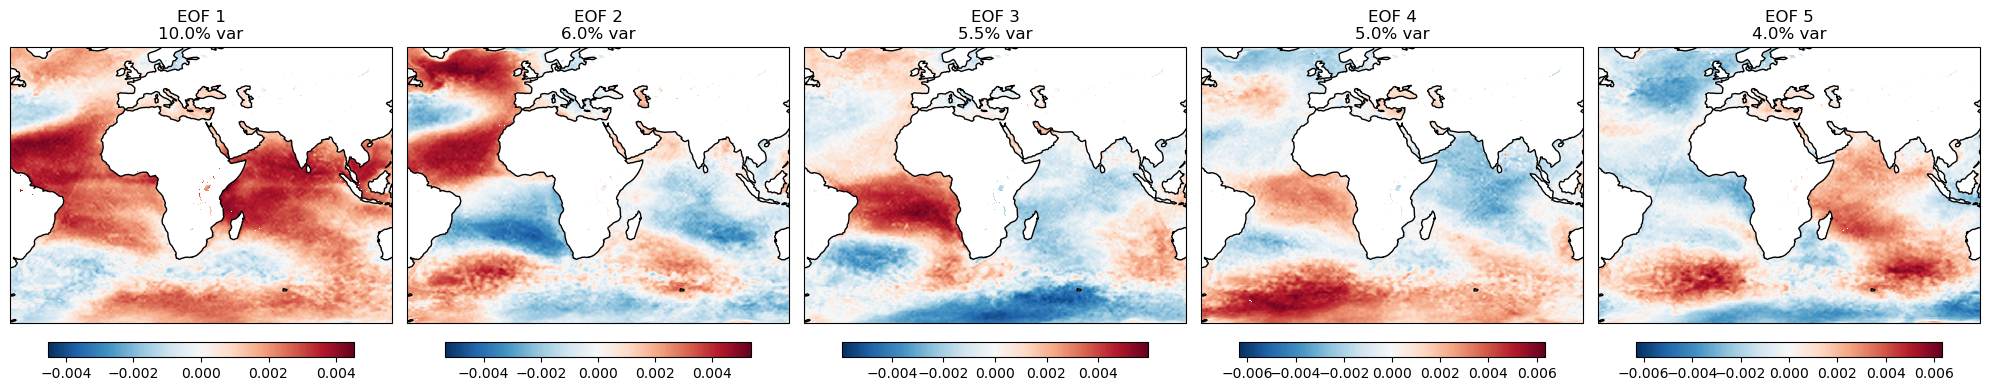

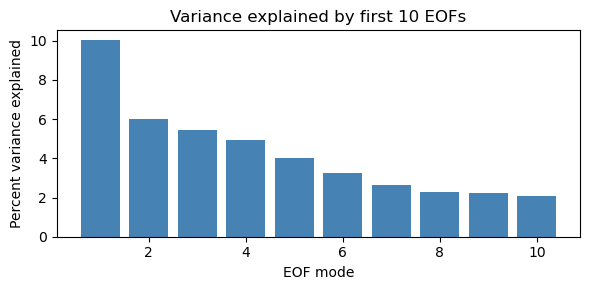

In [8]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1,5,figsize=(20,4),subplot_kw={"projection":proj})
for i in range(5):
    eof = EOF_maps.sel(mode=i+1)
    vmax = np.nanmax(np.abs(eof))
    im = axes[i].pcolormesh(EOF_maps.longitude, EOF_maps.latitude, eof,
                            cmap="RdBu_r", vmin=-vmax, vmax=vmax, transform=proj)
    axes[i].coastlines()
    axes[i].set_title(f"EOF {i+1}\n{explained[i]*100:.1f}% var")
    plt.colorbar(im, ax=axes[i], orientation="horizontal", pad=0.05, shrink=0.8)
plt.tight_layout()

plt.figure(figsize=(6,3))
plt.bar(np.arange(1,11), 100*explained[:10], color="steelblue")
plt.xlabel("EOF mode"); plt.ylabel("Percent variance explained")
plt.title("Variance explained by first 10 EOFs")
plt.tight_layout(); plt.show()


c:\Users\tomy3\miniforge3\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\tomy3\miniforge3\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


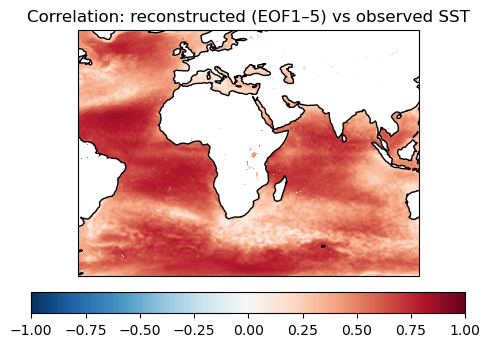

In [9]:
# --- Reconstruct SST anomalies using first 5 EOFs ---
n_recon = 5
X_recon = PCs[:, :n_recon] @ EOFs[:n_recon, :]   # (time, points)

# Put back into xarray
sst_recon = xr.DataArray(
    X_recon,
    dims=["valid_time","points"],
    coords={"valid_time": sst_stacked["valid_time"], "points": sst_stacked.points}
).unstack("points")

sst_recon.name = "sst_recon"

# --- Correlation with observed standardized SST ---
corr = xr.corr(sst_stdzd, sst_recon, dim="valid_time")

# --- Plot correlation map ---
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(8,4), subplot_kw={"projection": proj})
im = ax.pcolormesh(
    corr.longitude, corr.latitude, corr,
    cmap="RdBu_r", vmin=-1, vmax=1, transform=proj
)
ax.coastlines()

ax.set_title("Correlation: reconstructed (EOF1–5) vs observed SST")
plt.colorbar(im, ax=ax, shrink=0.7, orientation="horizontal", pad=0.05)
plt.show()